# Model To Indentify and Classify Dog Emotions

## Importing Libraries
**Following are the required libraries and how they are imported**

In [2]:
# system library
import os

# math and tables
import pandas as pd
import numpy as np

# for model building
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
tf.random.set_seed(42)

# visualization libraries
import cv2
import matplotlib.pyplot as plt

# some utils
from sklearn.model_selection import train_test_split
from random import randint


## Defining Dataset
**The following section define the path of dataset uploaded and creates the usable dataset - Images and Labels**

In [3]:
data_path = '/kaggle/input/dog-emotion/Dog Emotion/'

class_names = sorted(os.listdir(data_path))
# remove labels.csv because it's not a class
class_names.remove('labels.csv')
num_classes = len(class_names)

img_size = (192, 192, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')


images = []
labels = []
labels_df = pd.read_csv('/kaggle/input/dog-emotion/Dog Emotion/labels.csv')

print('\n\nlabels dataframe: \n', labels_df.head())

for image in labels_df.iloc:
    images.append(np.asarray(cv2.resize(cv2.imread(data_path + image[2] + '/' + image[1], cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1]))
    
    # labels will be in the form of a vector: [0, 1, 0, 0] or [1, 0, 0, 0]
    label = np.zeros(num_classes)
    label[class_names.index(image[2])] = 1
    labels.append(label)

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')

4 classes: ['angry', 'happy', 'relaxed', 'sad']
image size: (192, 192, 3)


labels dataframe: 
    Unnamed: 0                               filename    label
0           0  yubL63eiiPmoRru8Z2K2yRo0NnGDCL683.jpg      sad
1           1  c1tVljKiLM9q2zTBuQGWpxmzBuSeBR437.jpg      sad
2           2  RbzNOvY5GIAl3PSjIRTKpEkQs1NByq575.jpg    angry
3           3  gKujaBuWYezz0yWK9ydTFVi6LbQtXe397.jpg    angry
4           4  U0hJ2ryOu1IOuYpc01O7RngPYa8Xvz795.jpg  relaxed

labels shape: (4000, 4)
images shape: (4000, 192, 192, 3)


## Testing the dataset
**The following section plots some of the images in the dataset. It tests whether the created datsets are working properly or not**

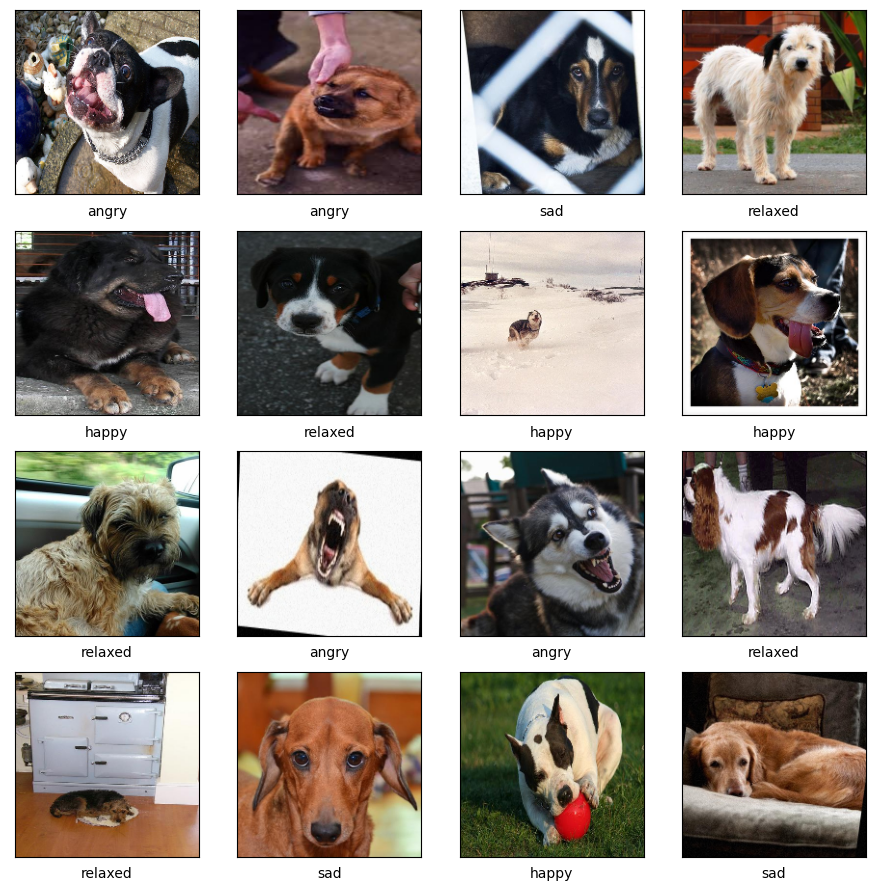

In [4]:
# Display 16 pictures from the dataset
fig, axs = plt.subplots(4, 4, figsize=(11, 11))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images))
        
        axs[x][y].imshow(images[i])
        
        # delete x and y ticks and set x label as picture label
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])
        
plt.show()

## Train - Test Splitting 
**This section splits the created dataset into training set (75%) and testing set (25%)**

In [5]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.25, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (3000, 192, 192, 3)
train labels shape: (3000, 4)

validation images shape: (1000, 192, 192, 3)
validation labels shape: (1000, 4)



## Defining the Architecture of the Model
**The model is defined suing Keras Sequential model and consists of different layers.**

**The first layer rescales the input images by dividing each pixel value by 255 to normalize them between 0 and 1.**

**The following layers are blocks of convolutional layers followed by max pooling layers, which learn and extract increasingly complex features from the images. After the last max pooling layer, there is a flatten layer which reshapes the output into a 1D array.**

**The dense block consists of four fully connected layers with decreasing number of neurons, which classify the image based on the features extracted from the convolutional layers.**

**The last layer uses a softmax activation function to output the probability of the input image belonging to each of the 4 classes.**

**The model is compiled using the Adamax optimizer, categorical cross-entropy loss, and accuracy as the evaluation metric.**

In [6]:
cnn_model = tf.keras.Sequential()

# Inputs and rescaling
cnn_model.add(tf.keras.layers.Rescaling(scale=1. / 255, input_shape=(img_size)))

# Convolutional block 1
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Convolutional block 2
cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Convolutional block 3
cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Convolutional block 4
cnn_model.add(tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())

# Dense block
cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


cnn_model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 192, 192, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 128)       32896     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 128)       65664     
                                                        

## Training the Model
**The folling section trains the model.**
A callback function **ModelCheckpoint** that saves the model weights for each epoch during training is created. The saved weights are stored in a directory named **cnn_model**, and each file is named model{epoch:02d} where epoch:02d is the epoch number formatted with 2 digits.
The CNN model is then trained using the **fit** method. It takes images and labels as input, as well as validation data **X_val, y_val** to test performance on unseen data. 
Finally the **history** object is created that stores the loss, accuracy metrics of each epoch.

In [7]:
# creating ModelChecpoint callback
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}')

In [8]:
history = cnn_model.fit(images, labels, epochs=15, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/15
125/125 [==============================] - 35s 184ms/step - loss: 1.3883 - accuracy: 0.2495 - val_loss: 1.3863 - val_accuracy: 0.2570
Epoch 2/15
125/125 [==============================] - 21s 171ms/step - loss: 1.3239 - accuracy: 0.3010 - val_loss: 1.2611 - val_accuracy: 0.3620
Epoch 3/15
125/125 [==============================] - 23s 182ms/step - loss: 1.2656 - accuracy: 0.3503 - val_loss: 1.2593 - val_accuracy: 0.3550
Epoch 4/15
125/125 [==============================] - 22s 174ms/step - loss: 1.2463 - accuracy: 0.3722 - val_loss: 1.2168 - val_accuracy: 0.4010
Epoch 5/15
125/125 [==============================] - 21s 172ms/step - loss: 1.2179 - accuracy: 0.3930 - val_loss: 1.1925 - val_accuracy: 0.4340
Epoch 6/15
125/125 [==============================] - 21s 172ms/step - loss: 1.1727 - accuracy: 0.4365 - val_loss: 1.1124 - val_accuracy: 0.5000
Epoch 7/15
125/125 [==============================] - 23s 182ms/step - loss: 1.1011 - accuracy: 0.4960 - val_loss: 0.9566 - val_ac

## Plotting the Accuracy and Loss

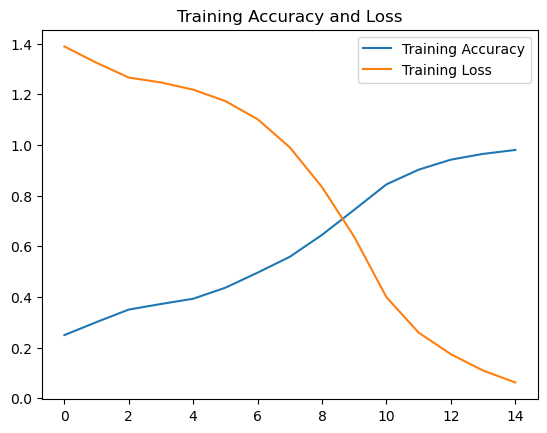

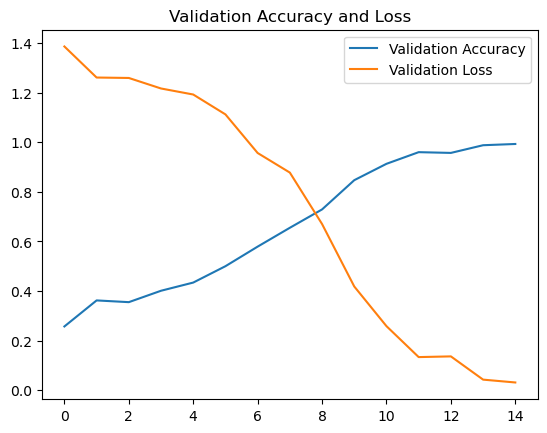

In [9]:
#accuracy and loss plot
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.legend()
plt.title('Training Accuracy and Loss')

plt.figure()
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.show()

## Testing the model
**Model is tested upon 28 images from testing dataset**

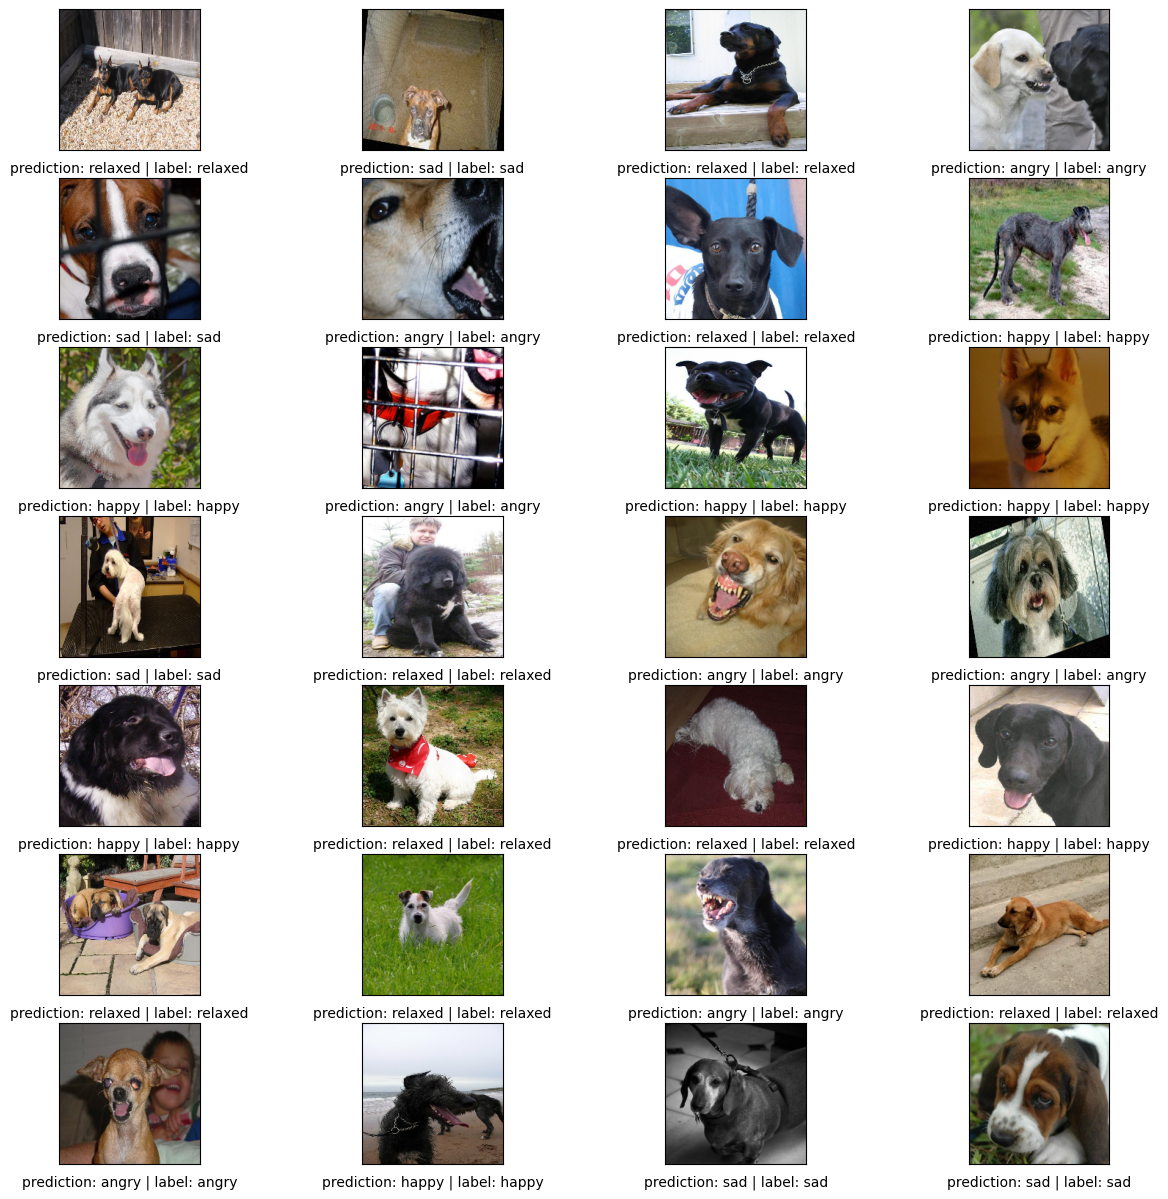

In [32]:
# Predictions
fig, axs = plt.subplots(7, 4, figsize=(15, 15))

i = 950
for x in range(7):
    for y in range(4):
        prediction = cnn_model.predict(X_val[i][None, ...], verbose=0)[0]
        
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')
        
        axs[x][y].imshow(X_val[i])
        
        i += 1
plt.show()

## Custom Input Test

In [55]:
# Load the image
image = np.asarray(cv2.resize(cv2.imread('/kaggle/input/dog-emotion/Dog Emotion/sad/1RNY5jJJlhTYvem20jta0JyuQKKB6b855.jpg', cv2.IMREAD_COLOR), img_size[0:2])[:, :, ::-1])

# Make a prediction
prediction = cnn_model.predict(image[np.newaxis, ...]) #rescaled_image to image

# Get the predicted class
predicted_class = np.argmax(prediction)

# Get the class name
class_name = class_names[predicted_class]

# Print the result
print(f'The model predicts that the dog is {class_name}')


1/1 [==============================] - 0s 22ms/step
The model predicts that the dog is sad
